# **xwOBA Model**

For this project, I am trying to design a model that can predict the wOBA value for balls in play using batted ball characteristics (launch speed and launch angle). I will be using data on balls in play from the 2020-2022 seasons (before the 2023 rule changes) to try to accurately predict a wOBA from these real data points. First, I will go through how I sorted and cleaned up the data, and we will look at an initial graph of launch angle vs. launch speed colored by outcome. Next, I will build the baseline model using the k-Nearest Neighbors method. This will allow me to get a preliminary assessment of the data and some rough estimates. From there, I will create another model using a Random Forest to compare against the original KNN model. Finally, I will calculate the final predictions for xwOBA and display them on a new graph of launch angle vs launch speed.

# Part 1 - Data collection

In [50]:
from pybaseball import statcast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier

For this project, I'll be using three years of data. This way it is recent, but is still measured **prior** to the 2023 rule changes.

In [4]:
three_year_data = statcast(start_dt="2020-07-23", end_dt="2022-11-05")

This is a large query, it may take a moment to complete


C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates
Skipping offseason dates


100%|████████████████████████████████████████████████████████████████████████████████| 579/579 [12:15<00:00,  1.27s/it]


Since I'm designing a process to find **xwOBAcon**, I'm only using balls in play.

In [6]:
contact_data = three_year_data[three_year_data['description'] == 'hit_into_play']
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
195,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,field_out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
202,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
213,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
222,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,field_out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
143,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,field_out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,field_out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
255,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
284,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,field_out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
338,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


Preliminary scatter plot of exit velocity and launch angle, colored by type of ball in play.

In [7]:
contact_data = contact_data.dropna(subset = ['launch_angle', 'launch_speed'])

Text(0.5, 0, 'Exit Velocity (mph)')

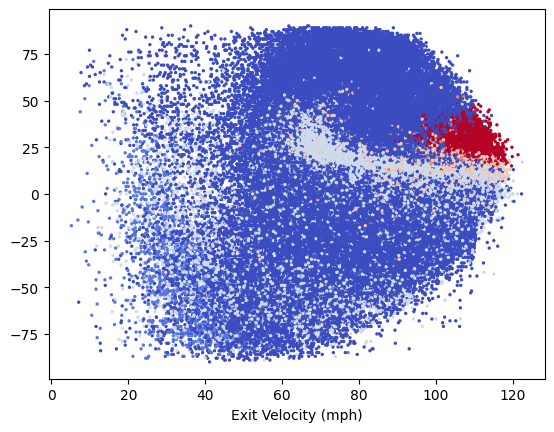

In [8]:
fig, ax = plt.subplots()
plt.scatter(x = contact_data['launch_speed'], y = contact_data['launch_angle'],
           c = contact_data['woba_value'], cmap = 'coolwarm', s = 2)
ax.set_xlabel('Exit Velocity (mph)')

To make it easier on our model, I am going to make every type of ball in play with a wOBA of 0 into "out." I also will be excluding catcher's interference because the swings were interfered with.

In [9]:
contact_data = contact_data.replace(['field_out', 'force_out', 'grounded_into_double_play', 
                                               'fielders_choice_out', 'sac_fly', 'field_error', 'sac_bunt_double_play',
                                              'fielders_choice', 'sac_bunt', 'double_play', 'triple_play',
                                              'sac_fly_double_play'], 'out')

In [10]:
contact_data.drop(contact_data[contact_data['events'] == 'catcher_interf'].index, inplace = True)

In [11]:
contact_data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
195,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,out,hit_into_play,...,4,1,4,1,4,Standard,Standard,137,0.011,-0.219
202,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,210,0.022,-0.3
213,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,...,4,1,4,1,4,Standard,Standard,212,-0.02,0.262
222,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,out,hit_into_play,...,4,1,4,1,4,Infield shift,Standard,120,0.018,-0.158
143,KC,2022-11-05,86.4,-2.67,5.86,"Robertson, David",663656,502085,out,hit_into_play,...,1,1,4,4,1,Infield shift,Standard,47,-0.001,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,FF,2020-07-23,96.4,-1.94,5.56,"Cole, Gerrit",607208,543037,out,hit_into_play,...,2,2,0,0,2,Standard,Standard,225,-0.022,-0.414
255,FF,2020-07-23,95.9,-3.16,5.49,"Scherzer, Max",519317,453286,home_run,hit_into_play,...,0,2,0,2,0,Standard,Standard,222,-0.18,1.787
284,SL,2020-07-23,86.7,-3.27,5.32,"Scherzer, Max",650402,453286,out,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,124,0.018,-0.335
338,FF,2020-07-23,96.7,-3.26,5.44,"Scherzer, Max",592450,453286,single,hit_into_play,...,0,0,0,0,0,Infield shift,Standard,220,-0.025,0.272


# Part 2 - Baseline model

Now that the data is set up, the baseline model for xwOBAcon can be built.

In [13]:
contact_data["events_encoded"] = [0 if x == "out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 for x in contact_data["events"]]

The model will make its predictions based off the launch speed and launch angle, and predict a 0-4 value corresponding to the event. In order to build the model, the data will need to be split into training and testing data. This allows us to maintain a dataset to produce an unbiased estimate of model performance.

In [14]:
X = contact_data[["launch_speed", "launch_angle"]]
Y = contact_data[['events_encoded']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0, test_size = .2)

We have to scale the results because exit velocity can be any positive number, while launch angle can only be between -90 and 90. The KNN model uses the distance between observations to create its "neighborhoods" of similar values, so the measures need to be on the same scale. Standardizing our distances will give us a clearer, more accurate neighborhood. 

In [15]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [16]:
classifier = KNeighborsClassifier(n_neighbors = 23, p = 2, metric = 'euclidean', )

After scaling the data and using euclidean distance, the model can be trained.

In [17]:
classifier.fit(X_train, Y_train)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=23)

In [18]:
Y_pred = classifier.predict(X_test)

Below, there are individual probabilities, an accuracy score, and the actual outcome for each individual event.

In [20]:
classifier.predict_proba(X_test)

array([[0.04347826, 0.69565217, 0.2173913 , 0.04347826, 0.        ],
       [0.7826087 , 0.17391304, 0.04347826, 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.2173913 , 0.65217391, 0.13043478, 0.        , 0.        ],
       [0.86956522, 0.08695652, 0.        , 0.04347826, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ]])

In [21]:
print(accuracy_score(Y_test, Y_pred))

0.7645999272895528


In [22]:
print(Y_test)

      events_encoded
978                1
778                0
1612               0
2064               0
312                0
...              ...
3509               0
3209               0
3857               0
5118               0
2840               2

[60514 rows x 1 columns]


# Part 3 - Assessing the model

This section will take a closer look at the model and evaluate it a little bit, starting with the log loss metric.

In [46]:
Y_pred_proba = classifier.predict_proba(X_test)
log_loss(Y_test, Y_pred_proba)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


1.1554015290506743

Next, calibration curves will be displayed for each of the 5 outcomes.

# Out

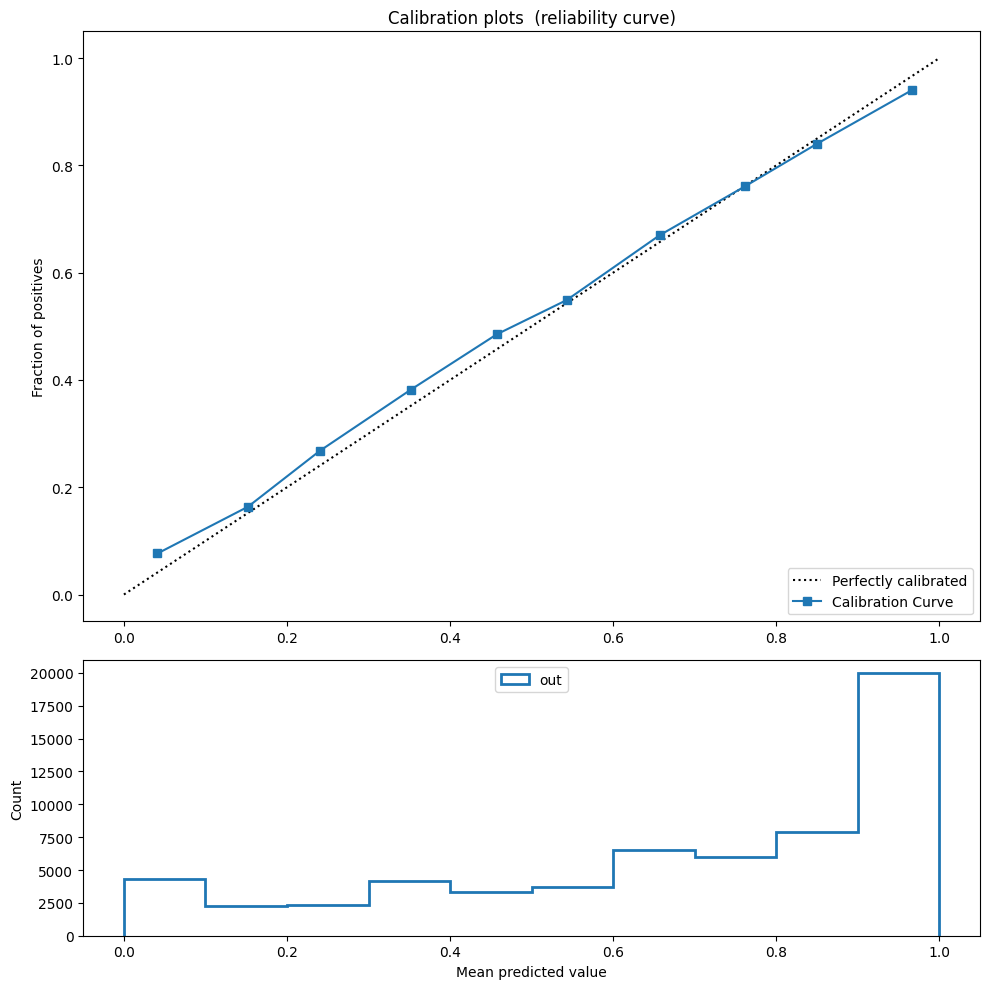

In [53]:
def plot_calibration_curve(outcome_type, Y_pred):
    """"Plot calibration curve for est w/o and with calibration.
    
    outcome_type: One of "out", "single", "double", "triple",
        or "home_run"
    """

    # Establish figure
    fig = plt.figure(0, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    # Map outcome to the original indices corresponding to
    # our target variable
    ind = 0 if outcome_type == "out" else \
        1 if outcome_type == "single" else \
        2 if outcome_type == "double" else \
        3 if outcome_type == "triple" else 4

    # Find the column in Y_pred_proba corresponding
    # to our output type
    prob_pos = Y_pred[:, ind]

    # Create the binary output variable. 1 if the value
    # from Y_test equals ind (our outcome type) and 0 otherwise
    y_binary = [1 if x == ind else 0 for x in Y_test["events_encoded"]]

    # Plotting
    ## Plot a line of perfect calibration
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    # Construct the calibration curve
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_binary, prob_pos, n_bins=10)

    # Plot the calibration curve
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="Calibration Curve")

    # Plot a histogram showing the volume of plays
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=outcome_type,
             histtype="step", lw=2)


    # Organize plots
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()


plot_calibration_curve("out", Y_pred_proba)

# Single

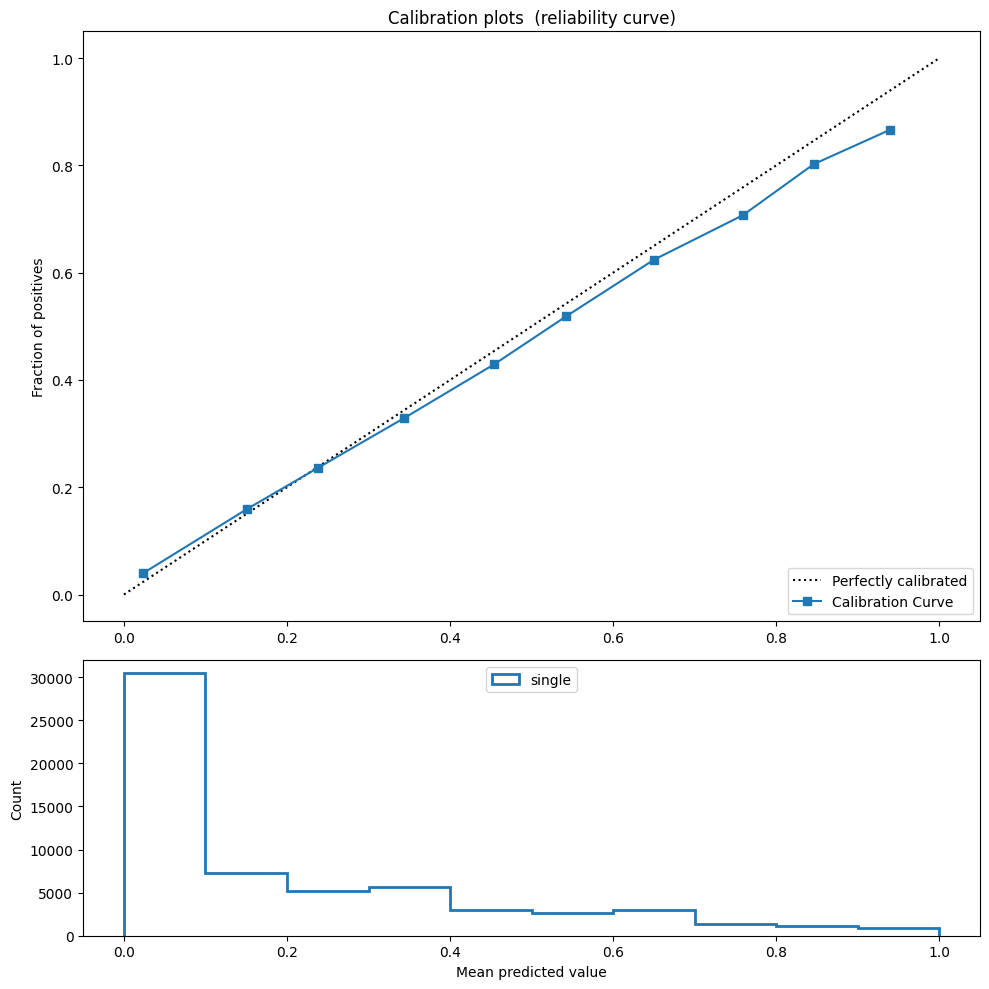

In [54]:
plot_calibration_curve("single", Y_pred_proba)

# Double

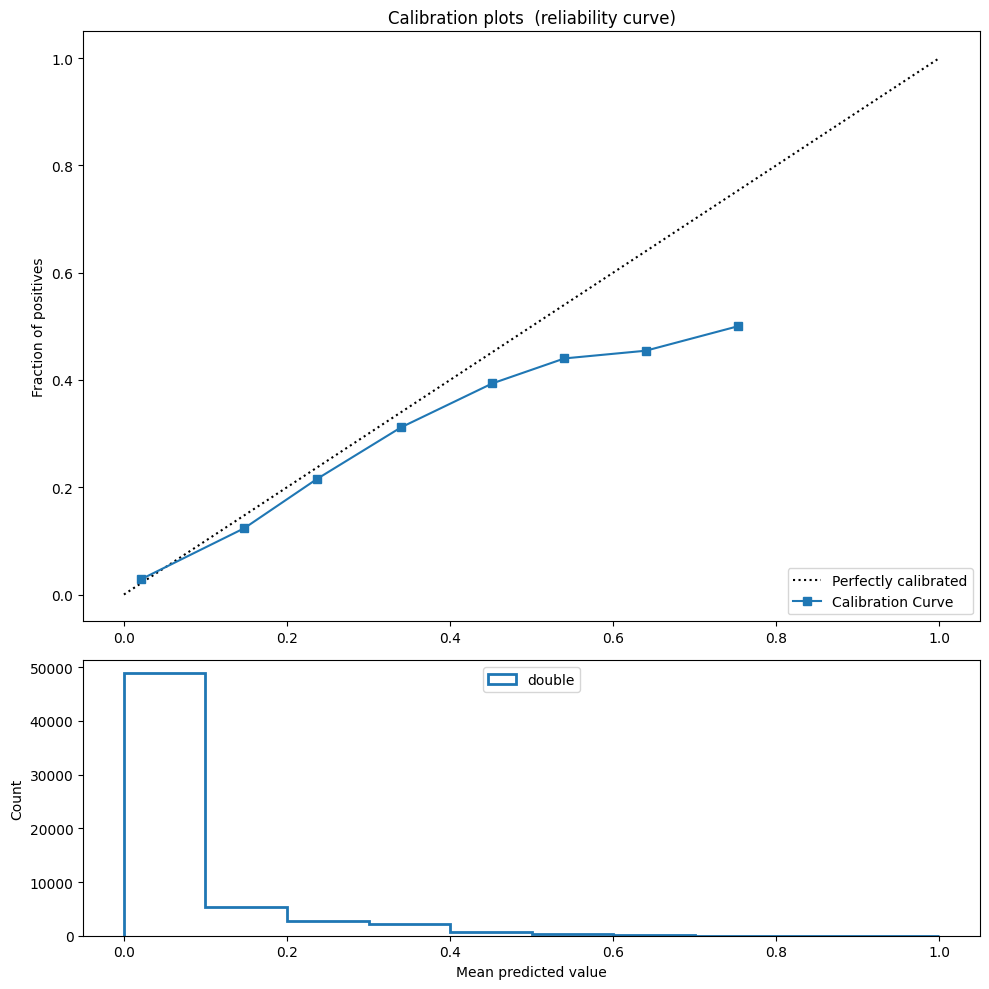

In [55]:
plot_calibration_curve("double", Y_pred_proba)

# Triple

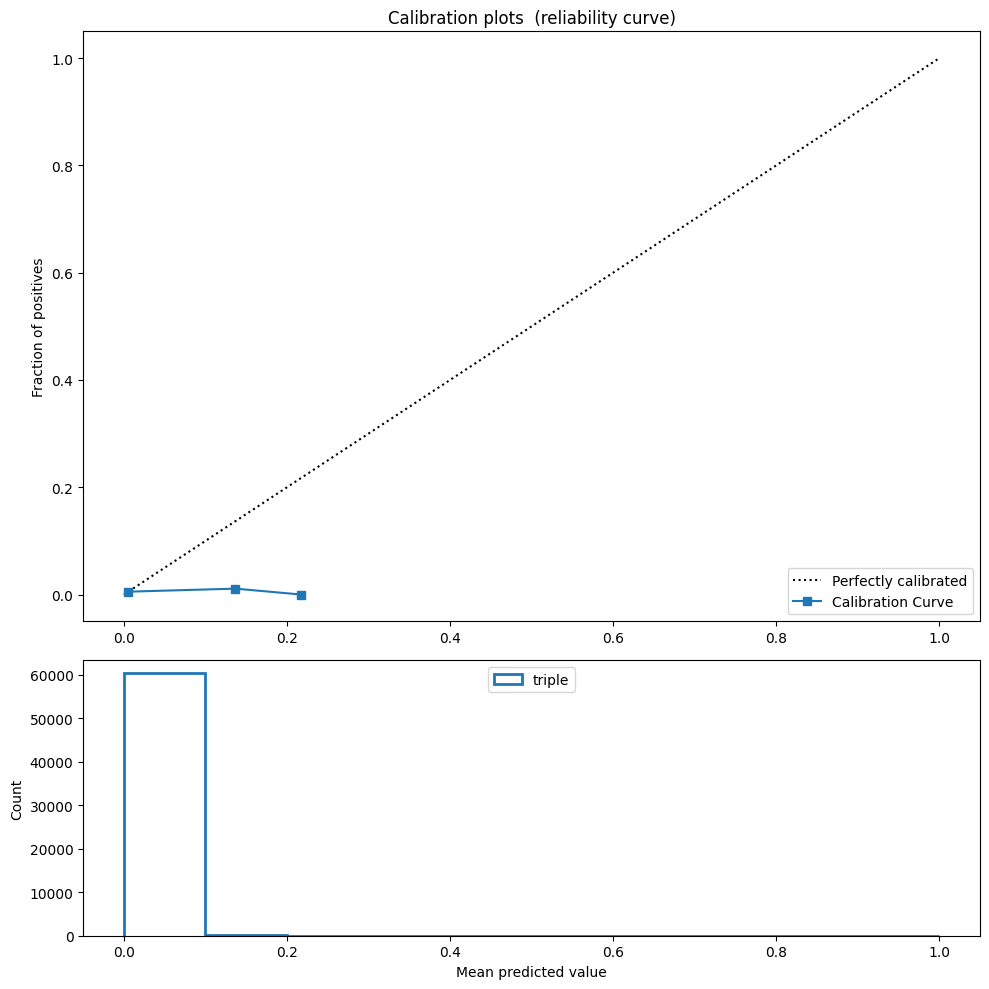

In [57]:
plot_calibration_curve("triple", Y_pred_proba)

# Home Run

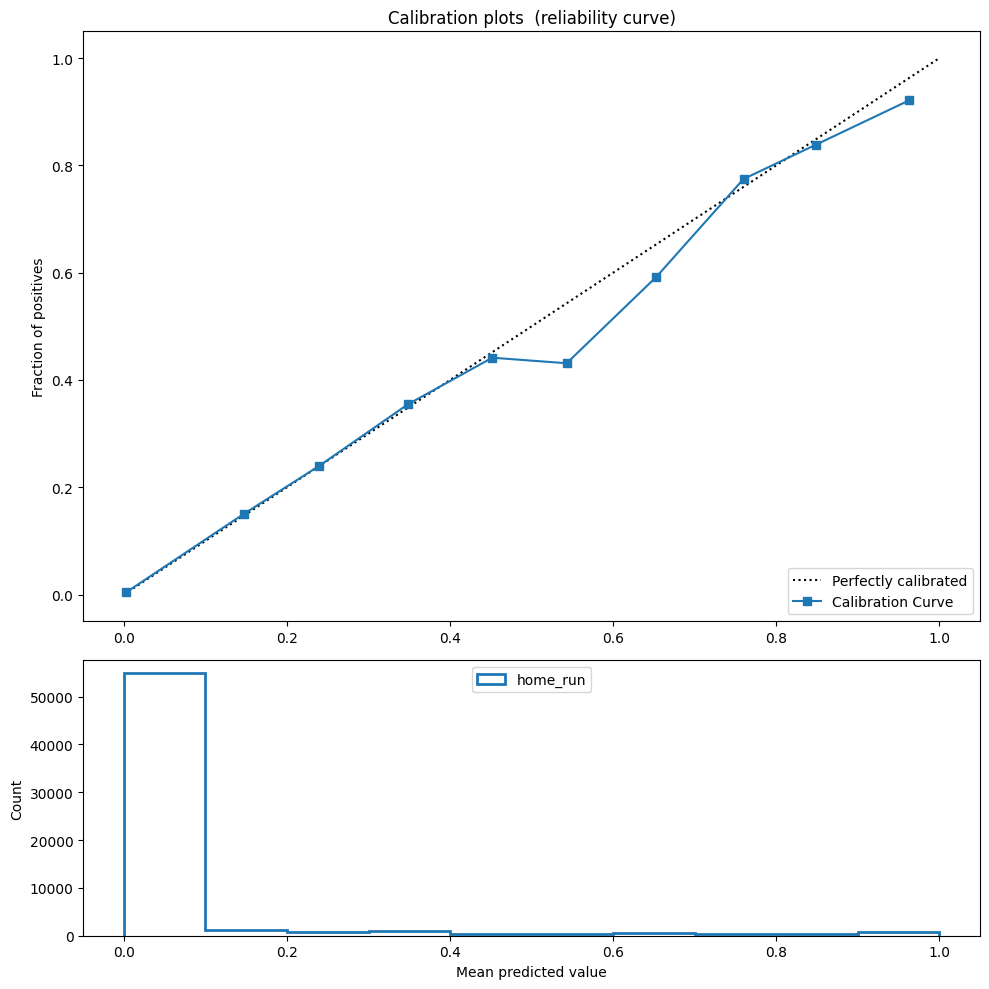

In [58]:
plot_calibration_curve("home_run", Y_pred_proba)

Lastly, for organization purposes, everything will be concatenated into the same dataframe.

In [30]:
X_test = pd.DataFrame(X_test, columns=["launch_speed", "launch_angle"])

In [31]:
pred_df = pd.DataFrame(classifier.predict_proba(X_test), columns=['out', 'single', 'double', 'triple', 'home_run'])
combined_df = pd.concat([X_test, pred_df], axis=1)
combined_df["output"] = list(Y_test["events_encoded"])

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [32]:
combined_df

,launch_speed,launch_angle,out,single,double,triple,home_run,output
0,1.116298,-0.043648,0.043478,0.695652,0.217391,0.043478,0.000000,1
1,0.870275,-0.559859,0.782609,0.173913,0.043478,0.000000,0.000000,0
2,-0.306646,0.954360,1.000000,0.000000,0.000000,0.000000,0.000000,0
3,-0.040675,-0.559859,0.739130,0.086957,0.173913,0.000000,0.000000,0
4,-2.793473,-2.831188,0.739130,0.260870,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...
60509,-1.882523,-2.383805,0.652174,0.347826,0.000000,0.000000,0.000000,0
60510,0.178751,0.644634,0.913043,0.000000,0.000000,0.000000,0.086957,0
60511,1.142895,-0.146890,0.217391,0.652174,0.130435,0.000000,0.000000,0
60512,0.118908,-0.869586,0.869565,0.086957,0.000000,0.043478,0.000000,0


# Random Forest

Even though a baseline has been established with the KNN model, a random forest model will be constructed. This will serve to both solidify the findings of the KNN model, as well as hopefully serve as an even more accurate and effective model.

In [33]:
forest_model = RandomForestClassifier(criterion = "log_loss", max_depth = 7)
forest_model.fit(X_train, Y_train)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='log_loss', max_depth=7)

In [34]:
forest_model.score(X_test, Y_test)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.770069735928876

As seen above, the random forest model has a slightly higher accuracy score than that of the KNN model. The models will be compared further using log_loss.

In [35]:
Y_pred_forest = forest_model.predict(X_test)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [51]:
Y_pred_proba_for = forest_model.predict_proba(X_test)
log_loss(Y_test, Y_pred_proba_for)

C:\Users\Chris Ayres\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.5900150458470594

The random forest model also has a much lower log loss value, showing even more evidence that this model is a better predictor of the correct outcome given launch angle and launch speed.

In [52]:
cm = confusion_matrix(Y_test, Y_pred_forest)
print(cm)

[[37444  2769   251     0   425]
 [ 5667  6782    86     0    26]
 [ 1924  1231   428     0   303]
 [  182    84    15     0    42]
 [  808     1   100     0  1946]]


# Out

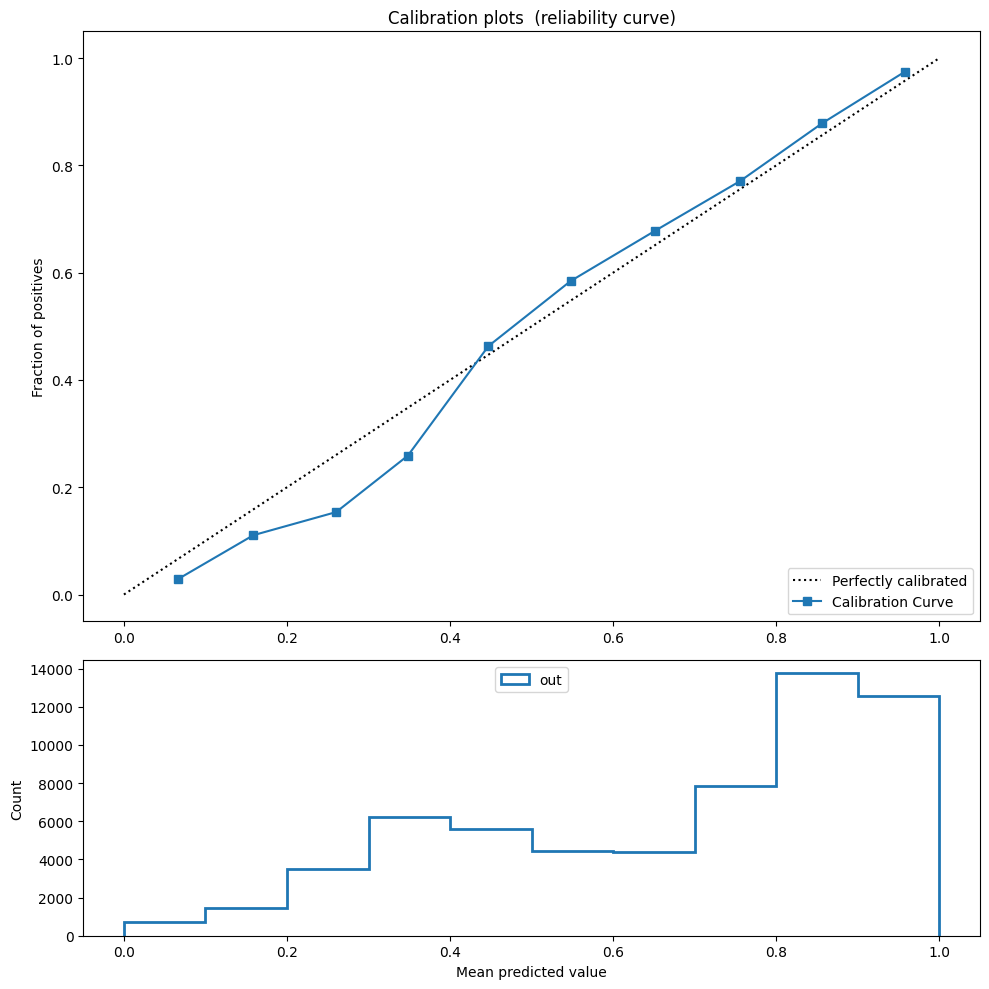

In [59]:
plot_calibration_curve("out", Y_pred_proba_for)

# Single

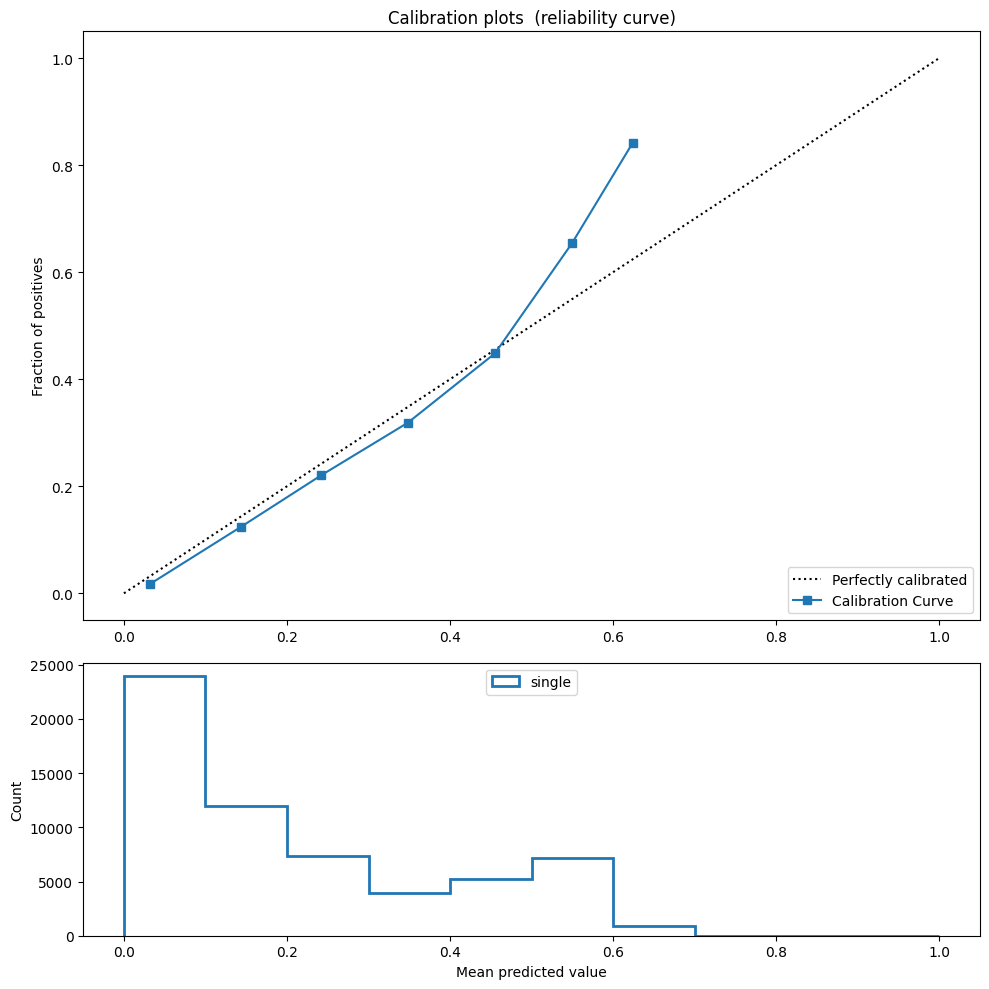

In [60]:
plot_calibration_curve("single", Y_pred_proba_for)

# Double

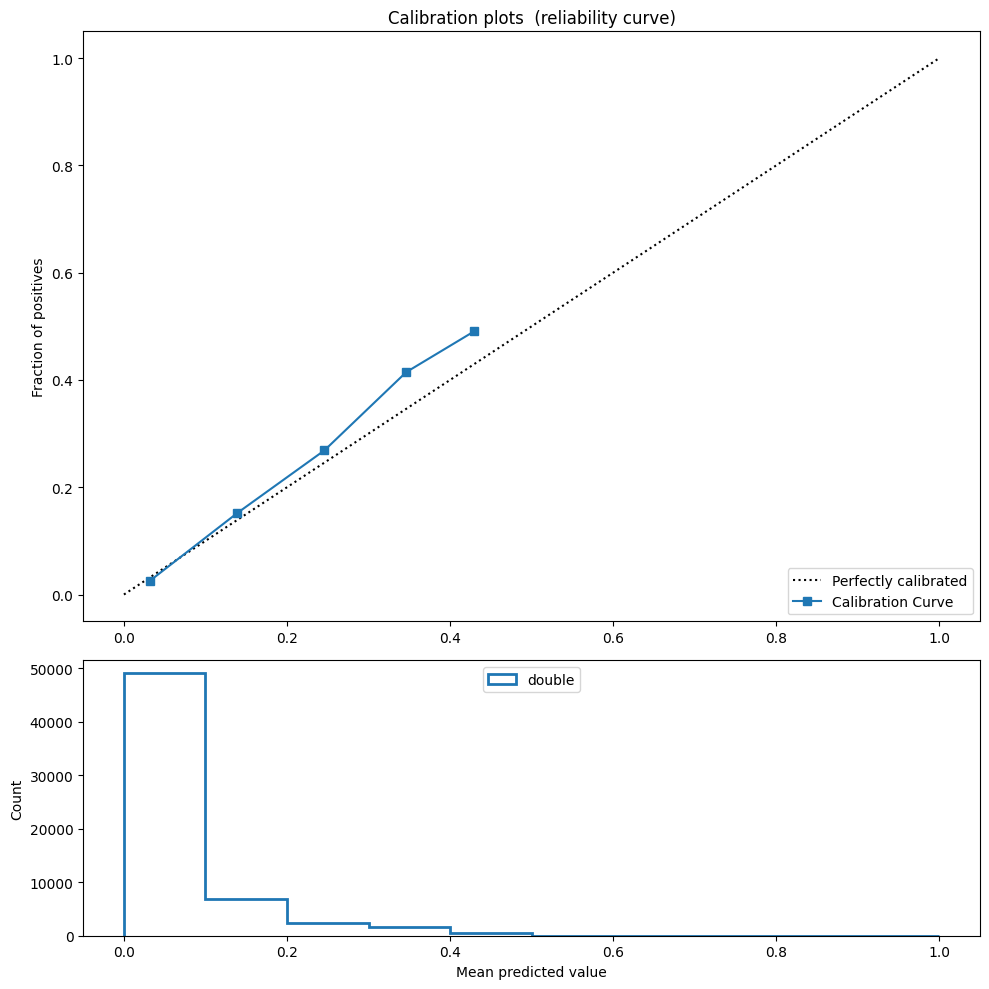

In [62]:
plot_calibration_curve("double", Y_pred_proba_for)

# Triple

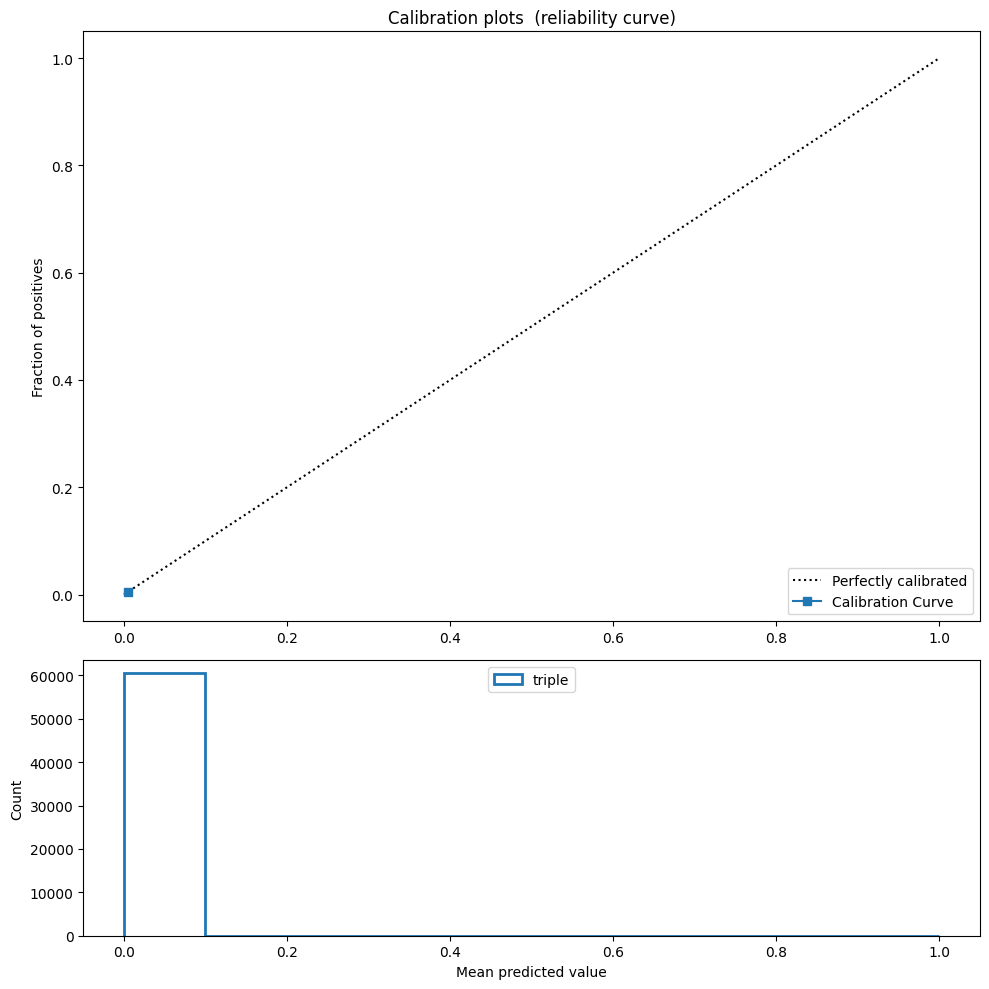

In [63]:
plot_calibration_curve("triple", Y_pred_proba_for)

# Home Run

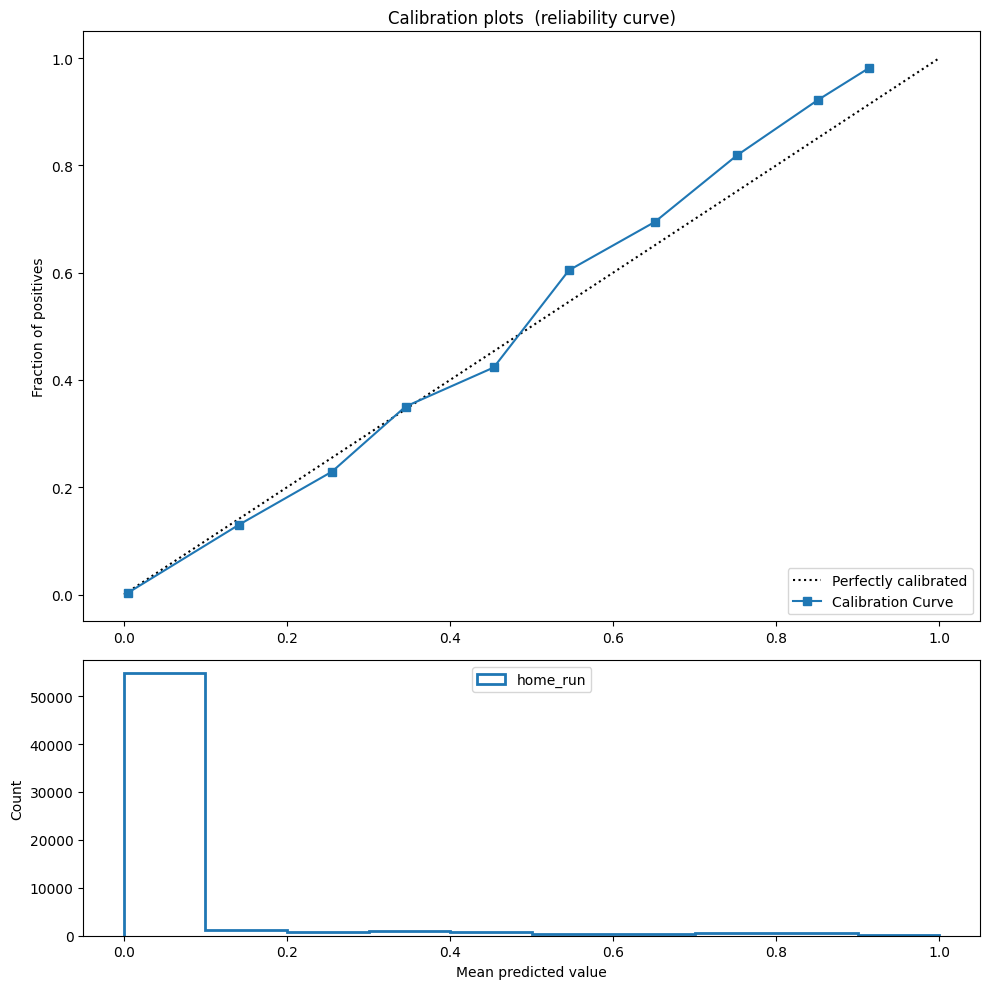

In [64]:
plot_calibration_curve("home_run", Y_pred_proba_for)

# Actual xwOBA

Here, I will finally get the xwOBA values for each ball in play. To do this, each value for the predicted outcomes will be multiplied by its wOBa values according to FanGraphs: 
Out = 0, Single = .89, Double = 1.27, Triple = 1.62, Home Run = 2.1

In [42]:
pred_df
woba_weights = np.array([0, 0.89, 1.27, 1.62, 2.1,])
xwoba_values = woba_weights * pred_df
xwoba_values["xwOBA"] = xwoba_values.sum(axis = 1)
xwoba_values

,out,single,double,triple,home_run,xwOBA
0,0.0,0.619130,0.276087,0.070435,0.000000,0.965652
1,0.0,0.154783,0.055217,0.000000,0.000000,0.210000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.077391,0.220870,0.000000,0.000000,0.298261
4,0.0,0.232174,0.000000,0.000000,0.000000,0.232174
...,...,...,...,...,...,...
60509,0.0,0.309565,0.000000,0.000000,0.000000,0.309565
60510,0.0,0.000000,0.000000,0.000000,0.182609,0.182609
60511,0.0,0.580435,0.165652,0.000000,0.000000,0.746087
60512,0.0,0.077391,0.000000,0.070435,0.000000,0.147826


Lastly, I am going to reproduce the hit outcome graph from earlier, this time using the xwOBA value for the color scale. We have to inversely transform the launch angle and launch speed values from X_test in order to get our original, non-standardized values for the graph.

In [43]:
X_raw = sc_X.inverse_transform(X_test)
X_raw

array([[104.9,  11. ],
       [101.2,  -4. ],
       [ 83.5,  40. ],
       ...,
       [105.3,   8. ],
       [ 89.9, -13. ],
       [ 82.1,  37. ]])

Text(0.5, 0, 'Exit Velocity (mph)')

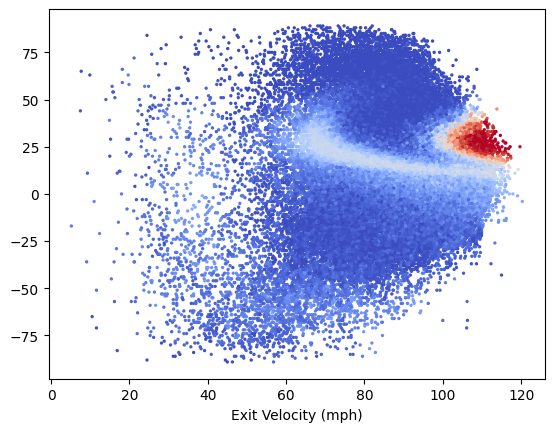

In [44]:
fig, ax = plt.subplots()
plt.scatter(x = X_raw[:, 0], y = X_raw[:, 1],
           c = xwoba_values["xwOBA"], cmap = 'coolwarm', s = 2)
ax.set_xlabel('Exit Velocity (mph)')